In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator, LogLocator 
from matplotlib import transforms
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm
tqdm.pandas()

sns.set_color_codes("colorblind")
sns.set_theme(style="white")
sns.set_context("talk")
# sns.color_palette()
sns.color_palette("tab10")

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

/Users/kyle/miniconda3/envs/memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

In [2]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 5

figures_path = f"scale+time_figures/recitation_threshold_{RECITATION_THRESHOLD}/"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

In [3]:
memories_path = "usvsnsp/semantic-filters"
intermediate_path = "usvsnsp/semantic-filters-intermediate"
memories_dataset = DatasetDict()
pile_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
splits = [split for split in splits if "deduped" in split]
print(splits)

['pile_deduped_1.4b', 'memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'pile_deduped_410m', 'pile_deduped_2.8b', 'pile_deduped_160m', 'pile_deduped_6.9b', 'pile_deduped_1b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'pile_deduped_12b', 'memories_deduped_160m', 'pile_deduped_70m', 'memories_deduped_12b', 'memories_deduped_12b.103000', 'memories_deduped_12b.63000', 'memories_deduped_12b.23000', 'memories_deduped_12b.123000', 'memories_deduped_12b.83000', 'memories_deduped_12b.43000', 'memories_deduped_12b.143000']


In [4]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    if split == "memories_deduped_12b.143000":
        continue

    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else 143000
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.").replace("pile_", "")
    dataset_path = memories_path if checkpoint == 143000 else intermediate_path
    if "memories" in split: 
        # continue # Don't load memories since they're unnecessary for the first part of the analysis
        memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)
    else:
        pile_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

display(memories_dataset)
display(pile_dataset)

Loading datasets...
Split sample size: None


100%|██████████| 23/23 [11:28<00:00, 29.93s/it]


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'nl_scores', '0_8_snowc

DatasetDict({
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score'],
        num_rows: 5000000
    })
    deduped.410m: Dataset({
        features: ['sequence_id', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'nl_scores', '0_8_snow

In [5]:
split_to_param_count = {
    "70m": 70000000,
    "410m": 410000000,
    "160m": 160000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [6]:
def set_type(nl_score):
    if nl_score <= 0.4:
        return "Code"
    
    if nl_score >= 0.525:
        return "NL"
    
    return "Uncertain"    

def get_frame_from_split(dataset, split_name, is_pile_sample):
    current_frame = dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    current_frame["TrainingPercentage"] = 1 if checkpoint == "Final" else checkpoint / 143000
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = current_frame["memorization_score"] >= 1
    current_frame["IsPileSample"] = is_pile_sample
    current_frame["IsCode"] = current_frame["nl_scores"].apply(lambda x: x <= 0.45)
    current_frame["CodeType"] = current_frame["nl_scores"].apply(set_type)
    return current_frame


columns_to_drop = ["frequencies", "tokens", "text"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = get_frame_from_split(memories_dataset, split, False)
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = get_frame_from_split(pile_dataset, split, True)
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
combined_dataframe

Loading Pile: 100%|██████████| 8/8 [03:17<00:00, 24.68s/it]


,sequence_id,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,...,memorization_score,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,IsCode,CodeType
4999999,146403638,3.712891,5.739519,9.374301,53.803978,False,False,1,11740996961,2.282799e+09,...,0.00000,Final,1.00000,70m,70000000,True,False,True,False,Uncertain
1392363,28389141,3.718750,12.002856,7.046402,84.576958,False,False,1,11740996961,2.768590e+09,...,0.00000,Final,1.00000,70m,70000000,True,False,True,False,Uncertain
1392364,28390708,3.669922,15.481421,7.782652,120.486526,False,False,1,11740996961,1.831097e+09,...,0.00000,Final,1.00000,70m,70000000,True,False,True,False,Uncertain
1392365,28391631,3.689453,2.313667,1.719604,3.978590,False,False,1,11740996961,1.916607e+09,...,0.00000,Final,1.00000,70m,70000000,True,False,True,False,Uncertain
1392366,28402202,3.650391,1.934296,6.144555,11.885390,False,False,62,11740996961,2.507500e+09,...,0.00000,Final,1.00000,70m,70000000,True,False,True,True,Uncertain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273159,9069785,2.419922,4.043283,3.445634,13.931673,False,False,1,11740996961,5.018371e+08,...,0.09375,Final,1.00000,12b,12000000000,True,False,True,False,Uncertain
2273160,9074394,2.500000,7.942500,2.781092,22.088825,False,False,2,10346382453,1.170068e+09,...,0.06250,Final,1.00000,12b,12000000000,True,False,True,False,Uncertain
2273161,9075271,2.611328,5.185763,4.454333,23.099115,False,False,2,10346382453,1.622983e+09,...,0.00000,Final,1.00000,12b,12000000000,True,False,True,False,Uncertain
2273097,8861887,2.490234,5.837689,4.160680,24.288754,False,False,1,10346382453,1.886930e+09,...,0.06250,Final,1.00000,12b,12000000000,True,False,True,False,Uncertain


In [7]:
combined_dataframe = combined_dataframe[combined_dataframe["Model"] != "160m"]
combined_dataframe.value_counts("Model")

Model
12b     11590265
6.9b     6680296
2.8b     6355216
1.4b     6048104
1b       6032872
410m     5811040
70m      5411448
Name: count, dtype: int64

## Assign Examples to Taxonomy

In [8]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] > RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

100%|██████████| 47929241/47929241 [02:12<00:00, 361306.06it/s]
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_40419/1587675624.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)


Model  Checkpoint  category      
70m    Final       Not Memorized     4990571
410m   Final       Not Memorized     4979577
1b     Final       Not Memorized     4973065
1.4b   Final       Not Memorized     4972518
2.8b   Final       Not Memorized     4962857
6.9b   Final       Not Memorized     4952353
12b    Final       Not Memorized     4946005
                   Recitation        1609737
6.9b   Final       Recitation        1454501
12b    123000      Recitation        1308538
2.8b   Final       Recitation        1170922
12b    103000      Recitation         999867
1.4b   Final       Recitation         909486
1b     Final       Recitation         900058
12b    83000       Recitation         710823
410m   Final       Recitation         706964
12b    63000       Recitation         489629
70m    Final       Recitation         370270
12b    43000       Recitation         301146
       Final       Recollection       258397
6.9b   Final       Recollection       217560
12b    123000      Re

## Plot Graphs

In [9]:
# hardcoded order
categories = ["Recitation", "Reconstruction", "Recollection"]
TICK_SIZE = 14

### Figure: Count and Memories by Taxonomy Across Time and Scale

In [10]:
combined_memories_dataframe = combined_dataframe[combined_dataframe["IsPileSample"] == False]
combined_memories_dataframe

,sequence_id,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,...,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,IsCode,CodeType,category
388187,105882301,0.896484,3.439801,1.010610,3.476297,False,False,25689,11740996961,2.386503e+09,...,Final,1.000000,70m,70000000,True,True,False,False,Uncertain,Recitation
388186,105822604,0.858887,1.904534,1.007740,1.919276,False,False,44274,11740996961,1.741459e+09,...,Final,1.000000,70m,70000000,True,True,False,True,Uncertain,Recitation
388185,105666721,0.861328,2.014894,1.015032,2.045182,False,False,1496,11740996961,2.347908e+09,...,Final,1.000000,70m,70000000,True,True,False,True,Uncertain,Recitation
388184,105645878,0.828125,2.159808,1.036094,2.237765,False,False,136529,11740996961,2.668036e+09,...,Final,1.000000,70m,70000000,True,True,False,True,Uncertain,Recitation
388183,105609090,0.807617,3.600666,1.038975,3.741002,False,False,10940,10346382453,1.229704e+09,...,Final,1.000000,70m,70000000,True,True,False,True,Uncertain,Recitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39821,13328062,NaN,NaN,NaN,NaN,False,False,1746,11740996961,2.564234e+09,...,63000,0.440559,12b,12000000000,True,True,False,False,Uncertain,Recitation
39820,13322917,NaN,NaN,NaN,NaN,False,False,2,11740996961,1.240830e+09,...,63000,0.440559,12b,12000000000,True,True,False,True,Uncertain,Recollection
39819,13322582,NaN,NaN,NaN,NaN,False,False,1140,11740996961,2.139832e+09,...,63000,0.440559,12b,12000000000,True,True,False,False,NL,Recitation
39883,13559419,NaN,NaN,NaN,NaN,False,False,5,11740996961,8.108282e+08,...,63000,0.440559,12b,12000000000,True,True,False,True,Uncertain,Recollection


In [11]:
combined_memories_dataframe[combined_memories_dataframe["Model"] == "12b"].value_counts("TrainingPercentage")

TrainingPercentage
1.000000    1871216
0.860140    1564055
0.720280    1195578
0.580420     852068
0.440559     585067
0.300699     358863
0.160839     163418
Name: count, dtype: int64

In [12]:
# Create plot for data across 
counts_frame_scale = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
counts_frame_scale = counts_frame_scale[categories].dropna()
counts_frame_scale.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_scale)

intermediate_frame = combined_memories_dataframe[combined_memories_dataframe["Model"] == "12b"]
sorted_checkpoints = sorted(sorted(intermediate_frame["TrainingPercentage"].unique(), key=lambda x: int(x)))

counts_frame_time = intermediate_frame.value_counts(["TrainingPercentage", "category"]).unstack().reindex(sorted_checkpoints)
counts_frame_time = counts_frame_time[categories].dropna()
counts_frame_time.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_time)

category,Recitation,Reconstruction,Recollection
Param Count,,,
70000000,362550.0,30430.0,18468.0
410000000,690726.0,46076.0,74238.0
1000000000,878456.0,49253.0,105163.0
1400000000,887549.0,49435.0,111120.0
2800000000,1141180.0,52416.0,161620.0
6900000000,1416014.0,53968.0,210314.0
12000000000,1566369.0,55114.0,249733.0


category,Recitation,Reconstruction,Recollection
TrainingPercentage,,,
0.160839,137681,7960,17777
0.300699,301146,15379,42338
0.440559,489629,23333,72105
0.580420,710823,31260,109985
0.720280,999867,38999,156712
0.860140,1308538,47145,208372
1.000000,1566369,55114,249733


### Figure: Percents and Memories by Taxonomy Across Time and Scale

In [13]:
counts_frame = combined_memories_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())[categories].dropna()
display(counts_frame)

category,Recitation,Reconstruction,Recollection
Param Count,,,
70000000,362550.0,30430.0,18468.0
410000000,690726.0,46076.0,74238.0
1000000000,878456.0,49253.0,105163.0
1400000000,887549.0,49435.0,111120.0
2800000000,1141180.0,52416.0,161620.0
6900000000,1416014.0,53968.0,210314.0
12000000000,5514053.0,219190.0,857022.0


In [14]:
all_percents_time = []
for checkpoint in tqdm(sorted_checkpoints):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["TrainingPercentage"] == checkpoint]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_time.append({
            "TrainingPercentage": checkpoint,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="TrainingPercentage", columns="category", values="percent").reindex(sorted_checkpoints)
percents_frame_time.index = [f"{int(percent * 100)}%" for percent in percents_frame_time.index]
percents_frame_time = percents_frame_time[categories]
percents_frame_time.to_csv(f"percents_frame_time_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_time)

100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


category,Recitation,Reconstruction,Recollection
16%,0.842508,0.048709,0.108782
30%,0.839167,0.042855,0.117978
44%,0.836877,0.039881,0.123242
58%,0.834233,0.036687,0.129080
72%,0.836304,0.032619,0.131076
86%,0.836632,0.030143,0.133225
100%,0.845637,0.041009,0.113354


In [15]:
all_percents_scale = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Param Count"] == param_count]
    if len(model_examples) == 0:
        continue

    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in categories:
        all_percents_scale.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

# where Model != 160m
model_keys = [key for key in split_to_param_count.keys() if key != "160m"]
percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="category", values="percent").reindex(model_keys)
# change column order
percents_frame_scale = percents_frame_scale[categories]
percents_frame_scale.to_csv(f"percents_frame_scale_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_scale)

100%|██████████| 8/8 [00:02<00:00,  3.73it/s]


category,Recitation,Reconstruction,Recollection
Model,,,
70m,0.881156,0.073958,0.044885
410m,0.851655,0.056811,0.091534
1b,0.850498,0.047685,0.101816
1.4b,0.846814,0.047166,0.106020
2.8b,0.842065,0.038677,0.119258
6.9b,0.842717,0.032118,0.125165
12b,0.836697,0.033260,0.130044


## Figure: Combined Counts + Percents Plot

### Same chart but with bounded bar charts

category,Recitation,Reconstruction,Recollection
Param Count,,,
70000000,362550.0,30430.0,18468.0
410000000,690726.0,46076.0,74238.0
1000000000,878456.0,49253.0,105163.0
1400000000,887549.0,49435.0,111120.0
2800000000,1141180.0,52416.0,161620.0
6900000000,1416014.0,53968.0,210314.0
12000000000,1566369.0,55114.0,249733.0


category,Recitation,Reconstruction,Recollection
Model,,,
70m,0.881156,0.073958,0.044885
410m,0.851655,0.056811,0.091534
1b,0.850498,0.047685,0.101816
1.4b,0.846814,0.047166,0.106020
2.8b,0.842065,0.038677,0.119258
6.9b,0.842717,0.032118,0.125165
12b,0.836697,0.033260,0.130044


category,Recitation,Reconstruction,Recollection
TrainingPercentage,,,
0.160839,137681,7960,17777
0.300699,301146,15379,42338
0.440559,489629,23333,72105
0.580420,710823,31260,109985
0.720280,999867,38999,156712
0.860140,1308538,47145,208372
1.000000,1566369,55114,249733


category,Recitation,Reconstruction,Recollection
16%,0.842508,0.048709,0.108782
30%,0.839167,0.042855,0.117978
44%,0.836877,0.039881,0.123242
58%,0.834233,0.036687,0.129080
72%,0.836304,0.032619,0.131076
86%,0.836632,0.030143,0.133225
100%,0.845637,0.041009,0.113354


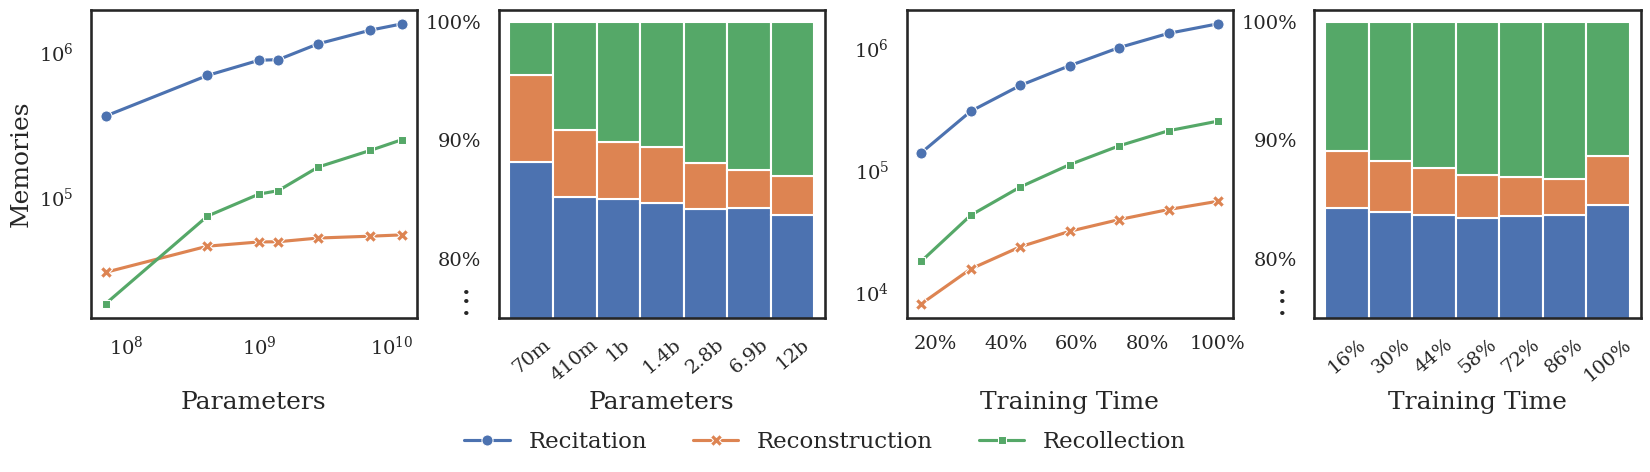

In [16]:
# Single row with four plots. Plot ordering is counts across scale, percents across scale, counts across time, percents across time
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

percents_figure_y_lim = (0.75, 1.01)
percents_figure_y_ticks = [0.8, 0.9, 1]

# set figure 1
display(counts_frame_scale)
sns.lineplot(ax=axes[0], data=counts_frame_scale, dashes=False, markers=True, markersize=8)
axes[0].tick_params(axis="x", labelsize=TICK_SIZE)
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].tick_params(axis="y", labelsize=TICK_SIZE)
axes[0].set_ylabel("Memories")
axes[0].set_xlabel("Parameters")
axes[0].legend(loc="upper center", bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False)

# set figure 2
display(percents_frame_scale)
percents_frame_scale.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[1].set_ylim(percents_figure_y_lim)
axes[1].set_yticks(percents_figure_y_ticks)
axes[1].tick_params(axis="x", rotation=40, labelsize=TICK_SIZE)
axes[1].tick_params(axis="y", labelsize=TICK_SIZE)
axes[1].set_xlabel("Parameters")
axes[1].get_legend().remove()

# Add ...
trans = transforms.blended_transform_factory(axes[1].transData, axes[1].transAxes)
axes[1].text(-1.5, 0.16, ".", fontsize=24, transform=trans, ha="center", va="top")
axes[1].text(-1.5, 0.13, ".", fontsize=24, transform=trans, ha="center", va="top")
axes[1].text(-1.5, 0.09, ".", fontsize=24, transform=trans, ha="center", va="top")

# set figure 3
display(counts_frame_time)
sns.lineplot(ax=axes[2], data=counts_frame_time, dashes=False, markers=True, markersize=8)
axes[2].set_yscale("log")
axes[2].tick_params(axis="x", labelsize=TICK_SIZE)
axes[2].tick_params(axis="y", labelsize=TICK_SIZE)
# axes[2].tick_params(axis="x", rotation=40)
axes[2].set_xlabel("Training Time")
axes[2].xaxis.set_major_formatter(PercentFormatter(1))
axes[2].legend().remove()

# set figure 4
display(percents_frame_time)
percents_frame_time.plot.bar(
    stacked=True,
    ax=axes[3],
    rot=0,
    width=1,
)
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[3].set_ylim(percents_figure_y_lim)
axes[3].set_yticks(percents_figure_y_ticks)
axes[3].tick_params(axis="x", rotation=40, labelsize=TICK_SIZE)
axes[3].tick_params(axis="y", labelsize=TICK_SIZE)
axes[3].set_xlabel("Training Time")
axes[3].get_legend().remove()

# Add ...
trans = transforms.blended_transform_factory(axes[3].transData, axes[3].transAxes)
axes[3].text(-1.5, 0.16, ".", fontsize=24, transform=trans, ha="center", va="top")
axes[3].text(-1.5, 0.13, ".", fontsize=24, transform=trans, ha="center", va="top")
axes[3].text(-1.5, 0.09, ".", fontsize=24, transform=trans, ha="center", va="top")


# make all the x labels have the same height
fig.align_xlabels()

# add padding between the plots
fig.subplots_adjust(wspace=0.25)

# Save the figure
fig.savefig(f"{figures_path}/categories_counts_percents_across_time+scale_bounded_bars.pdf", bbox_inches="tight")

## Code VS NL by Category Across Time and Scale

In [17]:
combined_memories_dataframe["category"].value_counts()

category
Recitation        10890528
Recollection       1537945
Reconstruction      500768
Name: count, dtype: int64

Plotting Categories: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_40419/2194115885.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


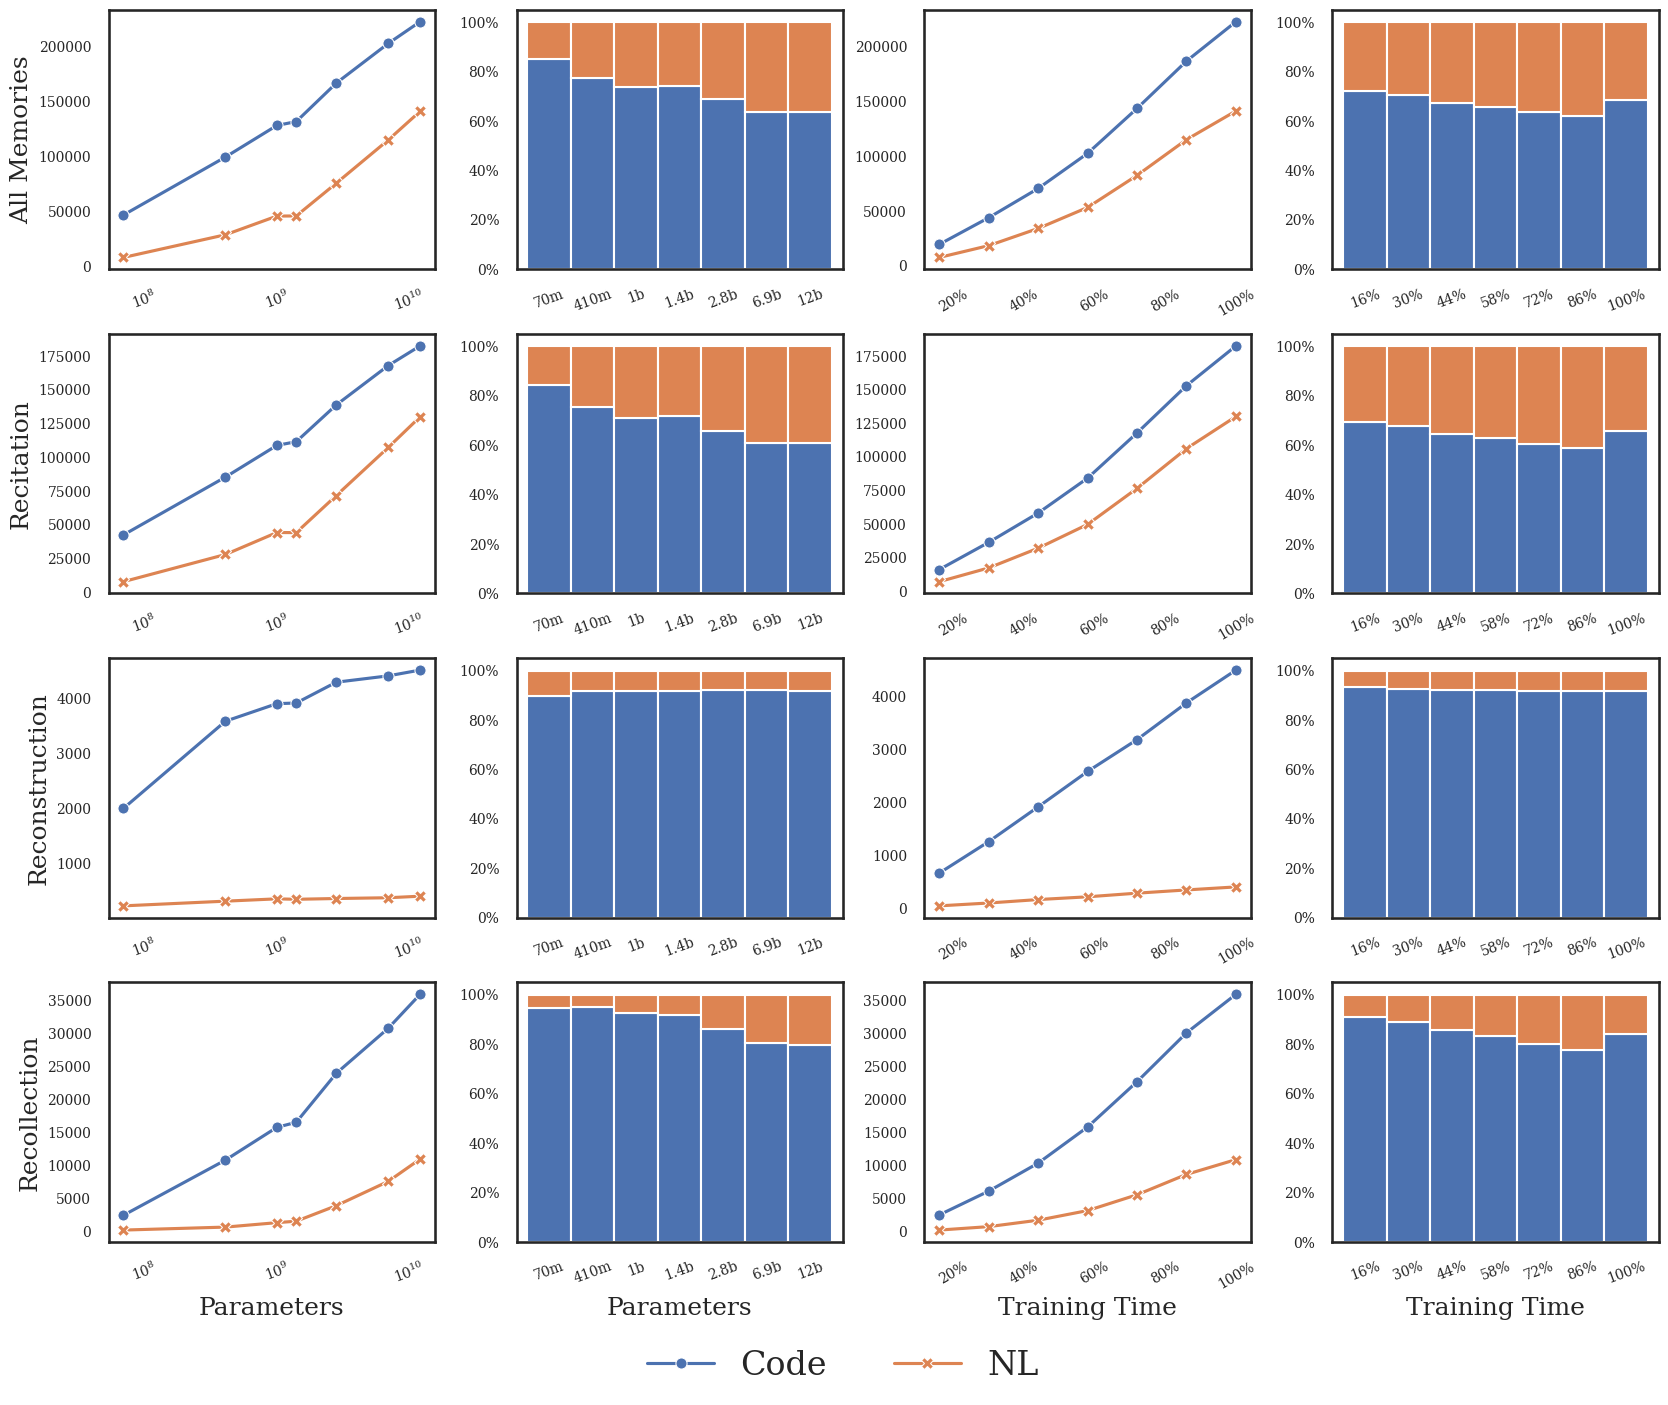

In [18]:
stats_dir = "./data/nl_vs_code_stats"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
for row_index, row_category in tqdm(enumerate(["All Memories", "Recitation", "Reconstruction", "Recollection"]), desc="Plotting Categories", total=4):
    row_frame = combined_memories_dataframe[combined_memories_dataframe["category"] == row_category] if row_category != "All Memories" else combined_memories_dataframe
    row_frame = row_frame[row_frame["CodeType"] != "Uncertain"]

    # Get the count of NL vs Code across scale
    nl_code_counts_frame_scale = row_frame[(row_frame["Checkpoint"] == "Final")].value_counts(["Param Count", "CodeType"]).unstack().reindex(split_to_param_count.values()).dropna()
    nl_code_counts_frame_scale.to_csv(f"{stats_dir}/{row_category}_counts_scale.csv")

    # Get the percent of NL vs Code across scale
    all_percents_scale = []
    for param_count in tqdm(split_to_param_count.values(), desc="Calculating Percents Across Scale"):
        model_examples = row_frame[row_frame["Param Count"] == param_count]
        model_percents = model_examples.value_counts("CodeType", normalize=True).to_dict()
        for category in model_percents:
            all_percents_scale.append({
                "Model": model_examples["Model"].unique()[0],
                "Param Count": param_count,
                "CodeType": category,
                "percent": model_percents[category],
            })
    
    nl_code_percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="CodeType", values="percent").reindex(model_keys)
    nl_code_percents_frame_scale.to_csv(f"{stats_dir}/{row_category}_percents_scale.csv")

    # set figure 1
    sns.lineplot(ax=axes[row_index, 0], data=nl_code_counts_frame_scale, dashes=False, markers=True, markersize=8)
    axes[row_index, 0].tick_params(axis='x', rotation=20, labelsize=10)
    axes[row_index, 0].set_xscale("log")
    axes[row_index, 0].tick_params(axis='y', labelsize=10)
    axes[row_index, 0].set_ylabel(row_category)
    axes[row_index, 0].set_xlabel("Parameters")

    # set figure 2
    nl_code_percents_frame_scale.plot.bar(
        stacked=True,
        ax=axes[row_index, 1],
        rot=0,
        width=1,
    )
    axes[row_index, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    axes[row_index, 1].tick_params(axis='x', rotation=20, labelsize=10)
    axes[row_index, 1].tick_params(axis='y', labelsize=10)

    # set figure 3
    intermediate_frame = row_frame[row_frame["Model"] == "12b"]
    sorted_checkpoints = sorted(sorted(intermediate_frame["TrainingPercentage"].unique(), key=lambda x: int(x)))
    nl_code_counts_frame_time = intermediate_frame.value_counts(["TrainingPercentage", "CodeType"]).unstack().reindex(sorted_checkpoints)
    nl_code_counts_frame_time.to_csv(f"{stats_dir}/{row_category}_counts_time.csv")
    
    sns.lineplot(ax=axes[row_index, 2], data=nl_code_counts_frame_time, dashes=False, markers=True, markersize=8)
    axes[row_index, 2].tick_params(axis='x', labelsize=10)
    axes[row_index, 2].tick_params(axis='y', labelsize=10)
    axes[row_index, 2].tick_params(axis='x', rotation=30)
    axes[row_index, 2].xaxis.set_major_formatter(PercentFormatter(1))

    # set figure 4
    all_percents_time = []
    for checkpoint in tqdm(sorted_checkpoints):
        model_examples = row_frame[(row_frame["TrainingPercentage"] == checkpoint)]
        model_percents = model_examples.value_counts("CodeType", normalize=True).to_dict()
        for category in model_percents:
            all_percents_time.append({
                "TrainingPercentage": checkpoint,
                "CodeType": category,
                "percent": model_percents[category],
            })
        
    nl_code_percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="TrainingPercentage", columns="CodeType", values="percent").reindex(sorted_checkpoints)
    nl_code_percents_frame_time.to_csv(f"{stats_dir}/{row_category}_percents_time.csv")
    nl_code_percents_frame_time.index = [f"{int(percent * 100)}%" for percent in nl_code_percents_frame_time.index]
    
    nl_code_percents_frame_time.plot.bar(
        stacked=True,
        ax=axes[row_index, 3],
        rot=0,
        width=1,
    )
    axes[row_index, 3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    axes[row_index, 3].tick_params(axis='x', rotation=20, labelsize=10)
    axes[row_index, 3].tick_params(axis='y', labelsize=10)

    # Set x labels for last row
    if row_index == 3:
        axes[row_index, 0].set_xlabel("Parameters")
        axes[row_index, 1].set_xlabel("Parameters")
        axes[row_index, 2].set_xlabel("Training Time")
        axes[row_index, 3].set_xlabel("Training Time")
    else:
        axes[row_index, 0].set_xlabel("")
        axes[row_index, 1].set_xlabel("")
        axes[row_index, 2].set_xlabel("")
        axes[row_index, 3].set_xlabel("")
    
    if row_index == 3:
        axes[row_index, 0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False, fontsize=24)
    else:
        axes[row_index, 0].get_legend().remove()
    
    axes[row_index, 1].get_legend().remove() if axes[row_index, 1].get_legend() else None
    axes[row_index, 2].get_legend().remove() if axes[row_index, 2].get_legend() else None
    axes[row_index, 3].get_legend().remove() if axes[row_index, 3].get_legend() else None

fig.align_xlabels()
plt.tight_layout()
plt.subplots_adjust(hspace=0.25, wspace=0.25)
fig.savefig(f"{figures_path}/nl_code_counts_percents_across_time+scale.pdf", bbox_inches="tight")

## Prob: Code VS NL by Category Across Time and Scale

In [19]:
pile_sample_frame = combined_dataframe[combined_dataframe["IsPileSample"] == True]
pile_sample_frame

,sequence_id,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,...,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,IsCode,CodeType,category
4999999,146403638,3.712891,5.739519,9.374301,53.803978,False,False,1,11740996961,2.282799e+09,...,Final,1.0,70m,70000000,True,False,True,False,Uncertain,Not Memorized
1392363,28389141,3.718750,12.002856,7.046402,84.576958,False,False,1,11740996961,2.768590e+09,...,Final,1.0,70m,70000000,True,False,True,False,Uncertain,Not Memorized
1392364,28390708,3.669922,15.481421,7.782652,120.486526,False,False,1,11740996961,1.831097e+09,...,Final,1.0,70m,70000000,True,False,True,False,Uncertain,Not Memorized
1392365,28391631,3.689453,2.313667,1.719604,3.978590,False,False,1,11740996961,1.916607e+09,...,Final,1.0,70m,70000000,True,False,True,False,Uncertain,Not Memorized
1392366,28402202,3.650391,1.934296,6.144555,11.885390,False,False,62,11740996961,2.507500e+09,...,Final,1.0,70m,70000000,True,False,True,True,Uncertain,Not Memorized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273158,9068535,2.871094,5.665259,3.630521,20.567841,False,False,1,11740996961,1.814504e+09,...,Final,1.0,12b,12000000000,True,False,True,False,NL,Not Memorized
2273159,9069785,2.419922,4.043283,3.445634,13.931673,False,False,1,11740996961,5.018371e+08,...,Final,1.0,12b,12000000000,True,False,True,False,Uncertain,Not Memorized
2273160,9074394,2.500000,7.942500,2.781092,22.088825,False,False,2,10346382453,1.170068e+09,...,Final,1.0,12b,12000000000,True,False,True,False,Uncertain,Not Memorized
2273161,9075271,2.611328,5.185763,4.454333,23.099115,False,False,2,10346382453,1.622983e+09,...,Final,1.0,12b,12000000000,True,False,True,False,Uncertain,Not Memorized


In [20]:
code_pile_sample = pile_sample_frame[pile_sample_frame["CodeType"] != "Uncertain"]
code_pile_sample

,sequence_id,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,...,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,IsCode,CodeType,category
1392367,28404821,3.642578,3.807533,4.598436,17.508696,False,False,2,11740996961,2.216143e+09,...,Final,1.0,70m,70000000,True,False,True,False,NL,Not Memorized
1392368,28408621,3.669922,7.007059,3.561281,24.954105,False,False,3,11740996961,1.962650e+09,...,Final,1.0,70m,70000000,True,False,True,False,NL,Not Memorized
1392370,28414804,3.632812,8.482560,8.693871,73.746284,False,False,2,11740996961,2.139942e+09,...,Final,1.0,70m,70000000,True,False,True,False,NL,Not Memorized
1392375,28434411,3.607422,13.692247,10.606048,145.220627,False,False,6,11740996961,1.285701e+09,...,Final,1.0,70m,70000000,True,False,True,False,NL,Not Memorized
1392361,28386409,3.589844,7.527973,5.400784,40.656956,False,False,2,11740996961,1.829423e+09,...,Final,1.0,70m,70000000,True,False,True,False,NL,Not Memorized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273163,9078387,2.593750,3.905556,3.488852,13.625908,False,False,2,11740996961,2.023191e+09,...,Final,1.0,12b,12000000000,True,False,True,False,NL,Not Memorized
2273147,9030967,2.974609,5.528403,4.403782,24.345882,False,False,2,11740996961,1.650516e+09,...,Final,1.0,12b,12000000000,True,False,True,False,NL,Not Memorized
2273148,9036211,2.703125,2.854457,4.011425,11.450440,False,False,1,11740996961,2.267963e+09,...,Final,1.0,12b,12000000000,True,False,True,False,NL,Not Memorized
2273155,9053662,2.414062,6.633667,6.578549,43.639896,False,False,1,11740996961,2.235376e+09,...,Final,1.0,12b,12000000000,True,False,True,False,NL,Not Memorized


In [21]:
code_pile_sample.value_counts("category")

category
Not Memorized     11386424
Recitation           36625
Recollection          5773
Reconstruction        1121
Name: count, dtype: int64

In [22]:
# Get percents of each Codetype
pile_code_nl_category_counts_scale = code_pile_sample.groupby(["Model", "category", "CodeType"]).size().unstack().to_dict()
pile_code_nl_category_counts_scale

{'Code': {('1.4b', 'Not Memorized'): 90265,
  ('1.4b', 'Recitation'): 3070,
  ('1.4b', 'Recollection'): 593,
  ('1.4b', 'Reconstruction'): 157,
  ('12b', 'Not Memorized'): 87249,
  ('12b', 'Recitation'): 5397,
  ('12b', 'Recollection'): 1265,
  ('12b', 'Reconstruction'): 174,
  ('1b', 'Not Memorized'): 90402,
  ('1b', 'Recitation'): 2959,
  ('1b', 'Recollection'): 567,
  ('1b', 'Reconstruction'): 157,
  ('2.8b', 'Not Memorized'): 89133,
  ('2.8b', 'Recitation'): 3936,
  ('2.8b', 'Recollection'): 843,
  ('2.8b', 'Reconstruction'): 173,
  ('410m', 'Not Memorized'): 91329,
  ('410m', 'Recitation'): 2221,
  ('410m', 'Recollection'): 385,
  ('410m', 'Reconstruction'): 150,
  ('6.9b', 'Not Memorized'): 87947,
  ('6.9b', 'Recitation'): 4880,
  ('6.9b', 'Recollection'): 1089,
  ('6.9b', 'Reconstruction'): 169,
  ('70m', 'Not Memorized'): 92789,
  ('70m', 'Recitation'): 1121,
  ('70m', 'Recollection'): 93,
  ('70m', 'Reconstruction'): 82},
 'NL': {('1.4b', 'Not Memorized'): 1537399,
  ('1.4b', 

In [23]:
all_memories_counts = {}
sample_types = ["Code", "NL"]
for sample_type in sample_types:
    for model_name, _ in pile_code_nl_category_counts_scale[sample_type]:
        if sample_type not in all_memories_counts:
            all_memories_counts[sample_type] = {}
        
        memories_count = 0
        for category_name in categories:
            memories_count += pile_code_nl_category_counts_scale[sample_type][(model_name, category_name)]
        
        all_memories_counts[sample_type][(model_name, "All Memories")] = memories_count
        all_samples_count = memories_count + pile_code_nl_category_counts_scale[sample_type][(model_name, "Not Memorized")]
        all_memories_counts[sample_type][(model_name, "All Samples")] = all_samples_count

for sample_type in all_memories_counts:
    for model_name, code_type in all_memories_counts[sample_type]:
        pile_code_nl_category_counts_scale[sample_type][(model_name, code_type)] = all_memories_counts[sample_type][(model_name, code_type)]

pile_code_nl_category_counts_scale

{'Code': {('1.4b', 'Not Memorized'): 90265,
  ('1.4b', 'Recitation'): 3070,
  ('1.4b', 'Recollection'): 593,
  ('1.4b', 'Reconstruction'): 157,
  ('12b', 'Not Memorized'): 87249,
  ('12b', 'Recitation'): 5397,
  ('12b', 'Recollection'): 1265,
  ('12b', 'Reconstruction'): 174,
  ('1b', 'Not Memorized'): 90402,
  ('1b', 'Recitation'): 2959,
  ('1b', 'Recollection'): 567,
  ('1b', 'Reconstruction'): 157,
  ('2.8b', 'Not Memorized'): 89133,
  ('2.8b', 'Recitation'): 3936,
  ('2.8b', 'Recollection'): 843,
  ('2.8b', 'Reconstruction'): 173,
  ('410m', 'Not Memorized'): 91329,
  ('410m', 'Recitation'): 2221,
  ('410m', 'Recollection'): 385,
  ('410m', 'Reconstruction'): 150,
  ('6.9b', 'Not Memorized'): 87947,
  ('6.9b', 'Recitation'): 4880,
  ('6.9b', 'Recollection'): 1089,
  ('6.9b', 'Reconstruction'): 169,
  ('70m', 'Not Memorized'): 92789,
  ('70m', 'Recitation'): 1121,
  ('70m', 'Recollection'): 93,
  ('70m', 'Reconstruction'): 82,
  ('1.4b', 'All Memories'): 3820,
  ('1.4b', 'All Sample

In [24]:
p_memorized_records = []
for sample_type in sample_types:
    for model_name, category in pile_code_nl_category_counts_scale[sample_type]:
        count_memories = pile_code_nl_category_counts_scale[sample_type][(model_name, category)]
        all_sample_type_count = pile_code_nl_category_counts_scale[sample_type][(model_name, "All Samples")]
        p_memorized = count_memories / all_sample_type_count
        p_memorized_records.append({
            "model": model_name,
            "category": category,
            "type": sample_type,
            "count": count_memories,
            "proportion": p_memorized
        })

p_memorized_frame_scale = pd.DataFrame(p_memorized_records)
p_memorized_frame_scale

,model,category,type,count,proportion
0,1.4b,Not Memorized,Code,90265,0.959398
1,1.4b,Recitation,Code,3070,0.032630
2,1.4b,Recollection,Code,593,0.006303
3,1.4b,Reconstruction,Code,157,0.001669
4,12b,Not Memorized,Code,87249,0.927342
...,...,...,...,...,...
79,410m,All Samples,NL,1538764,1.000000
80,6.9b,All Memories,NL,3629,0.002358
81,6.9b,All Samples,NL,1538764,1.000000
82,70m,All Memories,NL,211,0.000137


Plotting Categories: 100%|██████████| 4/4 [00:00<00:00, 78.92it/s]


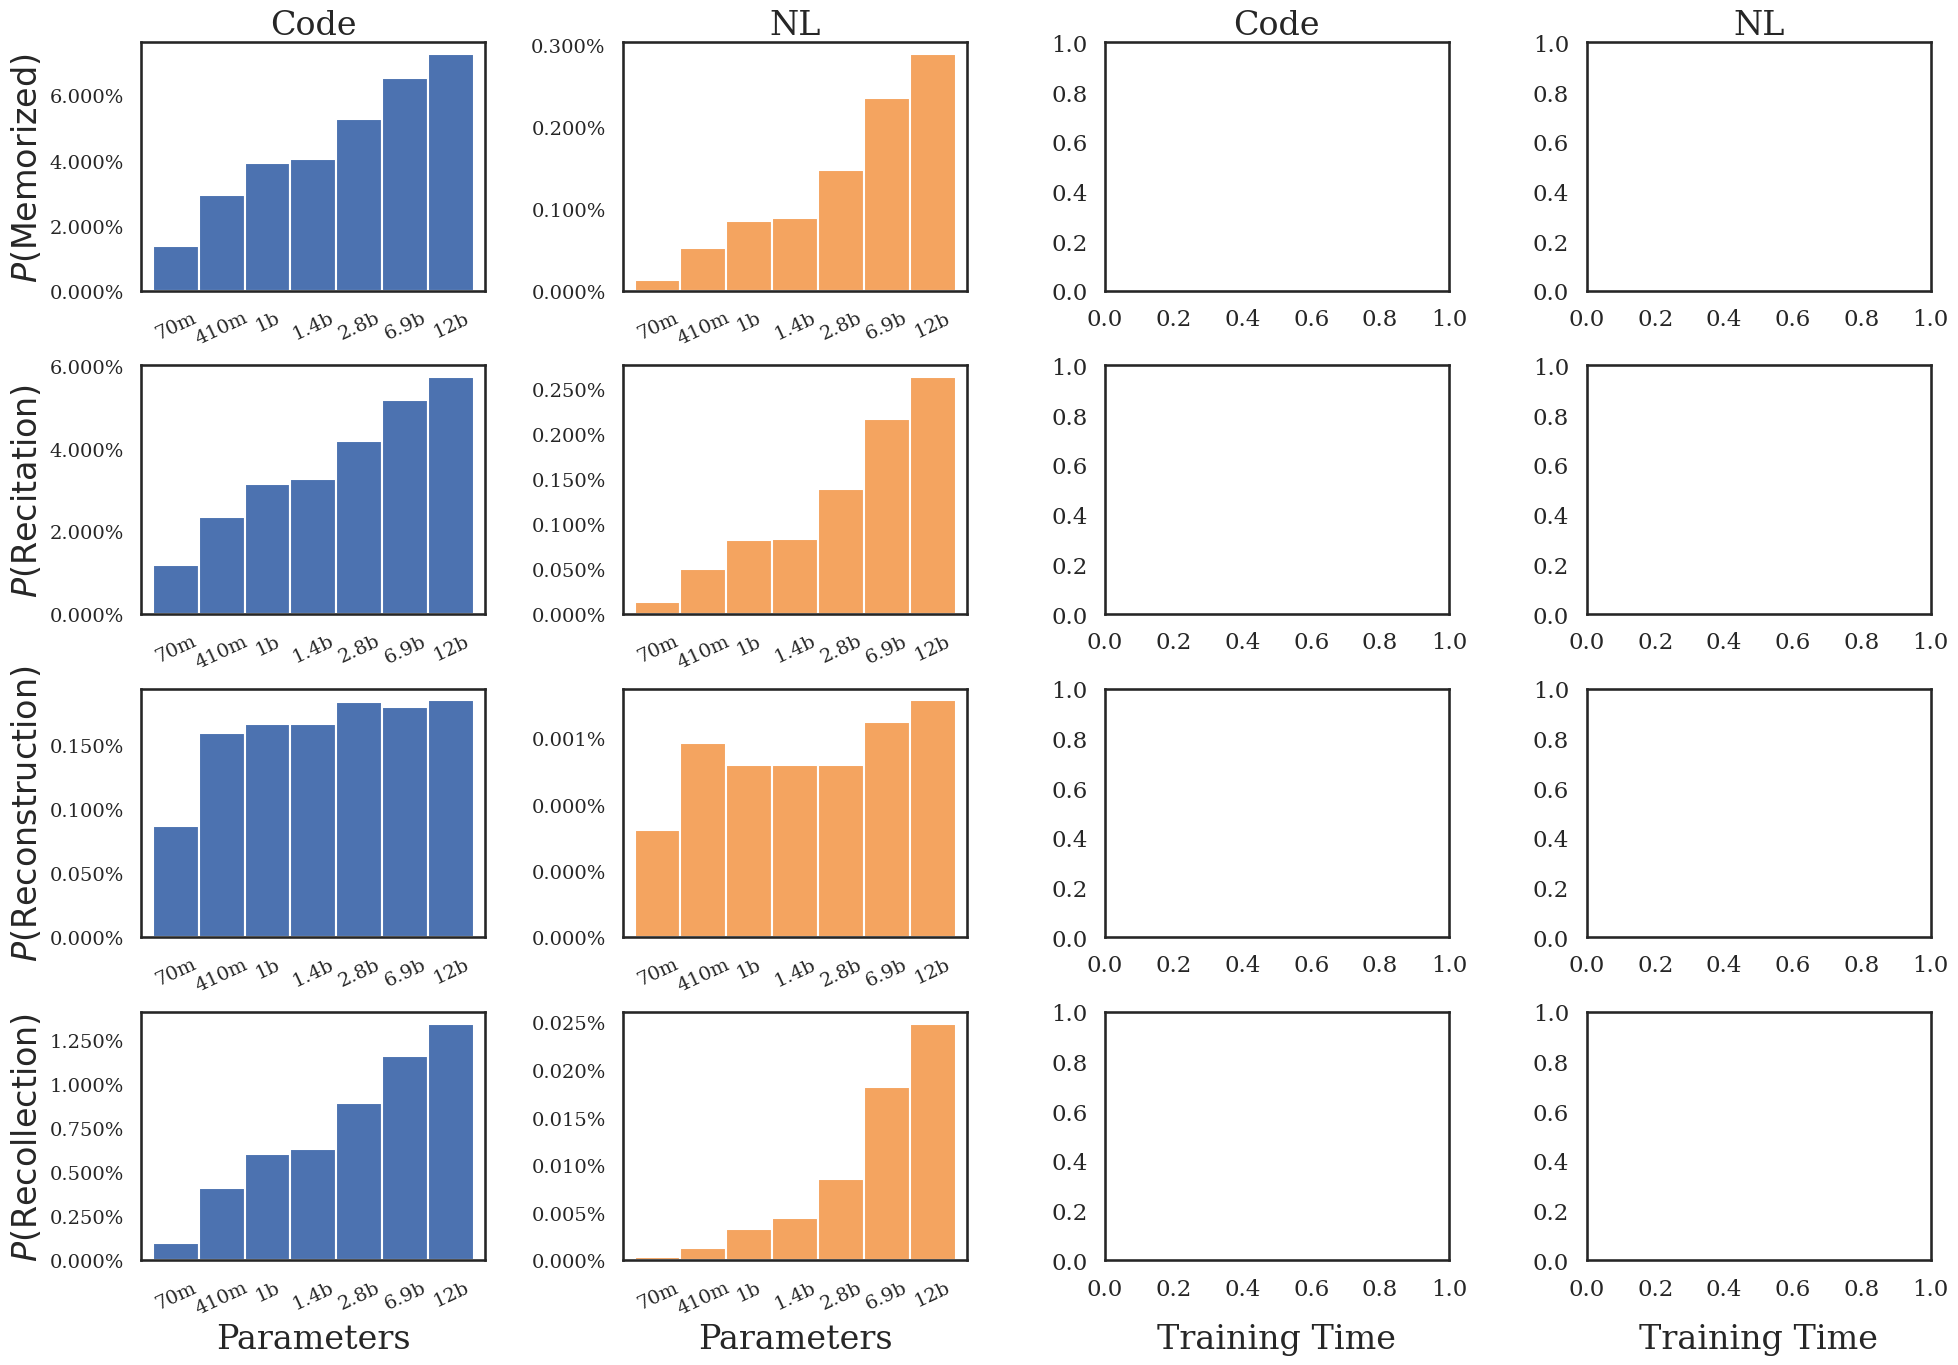

In [25]:
fig, axes = plt.subplots(4, 4, figsize=(20, 14))
row_label_map = {
    "All Memories": r"$P(\text{Memorized})$",
    "Recitation": r"$P(\text{Recitation})$",
    "Reconstruction": r"$P(\text{Reconstruction})$",
    "Recollection": r"$P(\text{Recollection})$"
}
for row_index, row_category in tqdm(enumerate(["All Memories", "Recitation", "Reconstruction", "Recollection"]), desc="Plotting Categories", total=4):
    row_counts_frame_code = p_memorized_frame_scale[(p_memorized_frame_scale["type"] == "Code") & (p_memorized_frame_scale["category"] == row_category)].set_index("model").reindex(split_to_param_count.keys()).dropna()
    row_counts_frame_code.plot.bar(stacked=True, ax=axes[row_index, 0], rot=0, width=1, y="proportion")
    axes[row_index, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}%".format(float(x * 100))))
    axes[row_index, 0].tick_params(axis="x", labelsize=14, rotation=25)
    axes[row_index, 0].tick_params(axis="y", labelsize=14)
    axes[row_index, 0].set_ylabel(row_label_map[row_category], fontsize=24)

    row_counts_frame_nl = p_memorized_frame_scale[(p_memorized_frame_scale["type"] == "NL") & (p_memorized_frame_scale["category"] == row_category)].set_index("model").reindex(split_to_param_count.keys()).dropna()
    row_counts_frame_nl.plot.bar(stacked=True, ax=axes[row_index, 1], rot=0, width=1, y="proportion", color="sandybrown")
    axes[row_index, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}%".format(float(x * 100))))
    axes[row_index, 1].tick_params(axis="x", labelsize=14, rotation=25)
    axes[row_index, 1].tick_params(axis="y", labelsize=14)

    if row_index == 0:
        axes[row_index, 0].set_title("Code", fontsize=24)
        axes[row_index, 1].set_title("NL", fontsize=24)
        axes[row_index, 2].set_title("Code", fontsize=24)
        axes[row_index, 3].set_title("NL", fontsize=24)

    if row_index == 3:
        axes[row_index, 0].set_xlabel("Parameters", fontsize=24)
        axes[row_index, 1].set_xlabel("Parameters", fontsize=24)
        axes[row_index, 2].set_xlabel("Training Time", fontsize=24)
        axes[row_index, 3].set_xlabel("Training Time", fontsize=24)
    else:
        axes[row_index, 0].set_xlabel("")
        axes[row_index, 1].set_xlabel("")
        axes[row_index, 2].set_xlabel("")
        axes[row_index, 3].set_xlabel("")
    
    axes[row_index, 0].get_legend().remove() if axes[row_index, 1].get_legend() else None
    axes[row_index, 1].get_legend().remove() if axes[row_index, 1].get_legend() else None
    axes[row_index, 2].get_legend().remove() if axes[row_index, 2].get_legend() else None
    axes[row_index, 3].get_legend().remove() if axes[row_index, 3].get_legend() else None

fig.align_xlabels()
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.4)
fig.savefig(f"{figures_path}/prob_memorized_nl_code_counts_percents_across_time+scale.pdf", bbox_inches="tight")

### Create LaTEX Table for Code Proportion by Category Across Time and Scale

In [29]:
# combined_counts_frame = None
combined_percents_frame = None

for file_name in os.listdir(stats_dir):
    category = file_name.split("_")[0]
    metric = file_name.split("_")[1].split(".")[0]
    if "counts" in metric:
        continue

    current_frame = pd.read_csv(f"{stats_dir}/{file_name}")
    current_frame["Category"] = category
    current_frame["Metric"] = metric

    if "TrainingPercentage" not in current_frame.columns:
        current_frame["TrainingPercentage"] = 1
    
    if "Param Count" not in current_frame.columns:
        current_frame["Param Count"] = 12000000000
    
    if "Unnamed: 0" in current_frame.columns:
        current_frame.rename(columns={"Unnamed: 0": "TrainingPercentage"}, inplace=True)

    if "Model" not in current_frame.columns:
        # swap keys and values in split_to_param_count
        param_count_to_split = {value: key for key, value in split_to_param_count.items()}
        current_frame["Model"] = current_frame["Param Count"].apply(lambda x: param_count_to_split[x])

    if combined_percents_frame is None:
        combined_percents_frame = current_frame
    else:
        combined_percents_frame = pd.concat([combined_percents_frame, current_frame])

# display(combined_counts_frame.head())
# display(combined_percents_frame.head())

display("Across Scale")

final_checkpoints_nl_code_percents = combined_percents_frame[combined_percents_frame["TrainingPercentage"] == 1].sort_values("Param Count")

# Across Scale
for model_size in list(split_to_param_count.keys()):
    if model_size == "160m":
        continue

    model_frame = final_checkpoints_nl_code_percents[final_checkpoints_nl_code_percents["Model"] == model_size]
    all_memories_row = model_frame[model_frame["Category"] == "All Memories"]
    recitation_row = model_frame[model_frame["Category"] == "Recitation"]
    reconstruction_row = model_frame[model_frame["Category"] == "Reconstruction"]
    recollection_row = model_frame[model_frame["Category"] == "Recollection"]

    latex_row = f"{model_size} & {all_memories_row['Code'].iloc[0]:.2%} & {all_memories_row['NL'].iloc[0]:.2%} & {recitation_row['Code'].iloc[0]:.2%} & {recitation_row['NL'].iloc[0]:.2%} & {reconstruction_row['Code'].iloc[0]:.2%} & {reconstruction_row['NL'].iloc[0]:.2%} & {recollection_row['Code'].iloc[0]:.2%} & {recollection_row['NL'].iloc[0]:.2%} \\\\"
    latex_row = latex_row.replace("%", "\%")
    print(latex_row)

display("Across Time")

# Across Time
intermediate_frame_nl_code_percents = combined_percents_frame[combined_percents_frame["Model"] == "12b"]
intermediate_frame_nl_code_percents.sort_values("TrainingPercentage", inplace=True)
intermediate_frame_nl_code_percents["TrainingPercentage"] = intermediate_frame_nl_code_percents["TrainingPercentage"].astype(str)
unqiue_checkpoints = intermediate_frame_nl_code_percents["TrainingPercentage"].unique()
for checkpoint in unqiue_checkpoints:
    model_frame = intermediate_frame_nl_code_percents[intermediate_frame_nl_code_percents["TrainingPercentage"] == checkpoint]
    all_memories_row = model_frame[model_frame["Category"] == "All Memories"]
    recitation_row = model_frame[model_frame["Category"] == "Recitation"]
    reconstruction_row = model_frame[model_frame["Category"] == "Reconstruction"]
    recollection_row = model_frame[model_frame["Category"] == "Recollection"]

    # print(checkpoint)
    # display(model_frame)
    # display(all_memories_row)
    # display(recitation_row)
    # display(reconstruction_row)
    # display(recollection_row)

    latex_row = f"{int(float(checkpoint) * 100)}% & {all_memories_row['Code'].iloc[0]:.2%} & {all_memories_row['NL'].iloc[0]:.2%} & {recitation_row['Code'].iloc[0]:.2%} & {recitation_row['NL'].iloc[0]:.2%} & {reconstruction_row['Code'].iloc[0]:.2%} & {reconstruction_row['NL'].iloc[0]:.2%} & {recollection_row['Code'].iloc[0]:.2%} & {recollection_row['NL'].iloc[0]:.2%} \\\\"
    latex_row = latex_row.replace("%", "\%")
    print(latex_row)


'Across Scale'

70m & 85.08\% & 14.92\% & 84.39\% & 15.61\% & 89.64\% & 10.36\% & 94.85\% & 5.15\% \\
410m & 77.53\% & 22.47\% & 75.31\% & 24.69\% & 91.88\% & 8.12\% & 94.87\% & 5.13\% \\
1b & 73.68\% & 26.32\% & 71.08\% & 28.92\% & 91.58\% & 8.42\% & 92.61\% & 7.39\% \\
1.4b & 74.14\% & 25.86\% & 71.63\% & 28.37\% & 91.78\% & 8.22\% & 91.77\% & 8.23\% \\
2.8b & 68.77\% & 31.23\% & 65.96\% & 34.04\% & 92.17\% & 7.83\% & 86.21\% & 13.79\% \\
6.9b & 63.81\% & 36.19\% & 61.02\% & 38.98\% & 92.09\% & 7.91\% & 80.36\% & 19.64\% \\
12b & 68.43\% & 31.57\% & 60.73\% & 39.27\% & 91.94\% & 8.06\% & 84.10\% & 15.90\% \\


'Across Time'

16\% & 72.13\% & 27.87\% & 69.22\% & 30.78\% & 93.29\% & 6.71\% & 91.16\% & 8.84\% \\
30\% & 70.53\% & 29.47\% & 67.62\% & 32.38\% & 92.52\% & 7.48\% & 88.89\% & 11.11\% \\
44\% & 67.47\% & 32.53\% & 64.47\% & 35.53\% & 91.99\% & 8.01\% & 85.65\% & 14.35\% \\
58\% & 65.86\% & 34.14\% & 62.85\% & 37.15\% & 92.20\% & 7.80\% & 83.21\% & 16.79\% \\
72\% & 63.53\% & 36.47\% & 60.60\% & 39.40\% & 91.72\% & 8.28\% & 80.24\% & 19.76\% \\
86\% & 61.87\% & 38.13\% & 59.03\% & 40.97\% & 91.76\% & 8.24\% & 77.63\% & 22.37\% \\
100\% & 63.60\% & 36.40\% & 65.91\% & 34.09\% & 91.94\% & 8.06\% & 79.89\% & 20.11\% \\


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_40419/2569186121.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate_frame_nl_code_percents.sort_values("TrainingPercentage", inplace=True)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_40419/2569186121.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate_frame_nl_code_percents["TrainingPercentage"] = intermediate_frame_nl_code_percents["TrainingPercentage"].astype(str)


# Feature Histograms

In [27]:
# 12b deduped final checkpoint
hists_plotting_frame = combined_dataframe[(combined_dataframe["Model"] == "12b") & (combined_dataframe["Checkpoint"] == "Final") & (combined_dataframe["Deduped"] == True)]
hists_plotting_frame = hists_plotting_frame.drop_duplicates(subset=["sequence_id"])
hists_plotting_frame

,sequence_id,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,...,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,IsCode,CodeType,category
1298289,44578411,0.655762,1.455822,1.010460,1.471049,False,False,1130,11740996961,3.038605e+09,...,Final,1.0,12b,12000000000,True,True,False,True,Uncertain,Recitation
1298288,44578114,0.742676,1.495425,1.011976,1.513334,False,False,166,11740996961,2.489103e+09,...,Final,1.0,12b,12000000000,True,True,False,False,NL,Recitation
1298287,44577532,0.698730,2.665272,1.009148,2.689653,True,False,2,11740996961,2.735383e+09,...,Final,1.0,12b,12000000000,True,True,False,True,Uncertain,Reconstruction
1298286,44577367,0.654785,3.291088,1.013148,3.334359,True,False,11,2965935634,3.873534e+08,...,Final,1.0,12b,12000000000,True,True,False,True,Code,Recitation
1298285,44576914,0.632812,1.334431,1.000647,1.335294,False,False,939,689751572,1.606489e+08,...,Final,1.0,12b,12000000000,True,True,False,True,Code,Recitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273158,9068535,2.871094,5.665259,3.630521,20.567841,False,False,1,11740996961,1.814504e+09,...,Final,1.0,12b,12000000000,True,False,True,False,NL,Not Memorized
2273159,9069785,2.419922,4.043283,3.445634,13.931673,False,False,1,11740996961,5.018371e+08,...,Final,1.0,12b,12000000000,True,False,True,False,Uncertain,Not Memorized
2273160,9074394,2.500000,7.942500,2.781092,22.088825,False,False,2,10346382453,1.170068e+09,...,Final,1.0,12b,12000000000,True,False,True,False,Uncertain,Not Memorized
2273161,9075271,2.611328,5.185763,4.454333,23.099115,False,False,2,10346382453,1.622983e+09,...,Final,1.0,12b,12000000000,True,False,True,False,Uncertain,Not Memorized


Plotting Features: 100%|██████████| 14/14 [00:39<00:00,  2.79s/it]


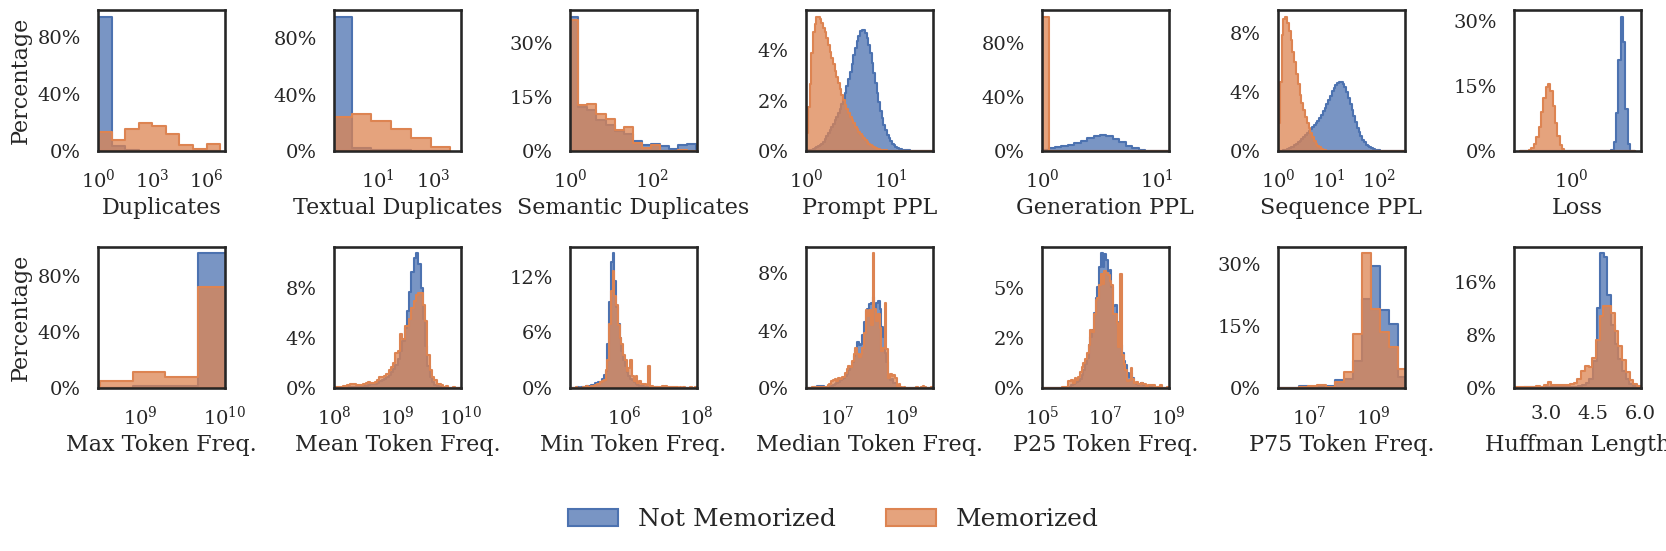

In [28]:
hist_splits = ["_deduped_12b"]
features = [
    "sequence_duplicates",
    "max_frequency",
    "avg_frequency",
    "min_frequency",
    "median_frequency",
    "p25_frequency", "p75_frequency",
    "0_8_templates", "huffman_coding_length", "prompt_perplexity", "generation_perplexity", "sequence_perplexity", "0_8_snowclones", "loss"
]
bins_per_feature = {
    "sequence_duplicates": 10,
    "max_frequency": 15,
    "avg_frequency": 150,
    "min_frequency": 150,
    "median_frequency": 100,
    "p25_frequency": 100,
    "p75_frequency": 20,
    "0_8_templates": 20,
    "prompt_perplexity": 100,
    "generation_perplexity": 35,
    "sequence_perplexity": 100, 
    "huffman_coding_length": 60, #dont take log scale for this feature 
    "0_8_snowclones": 60, 
    "loss": 50 
}
min_threshold = {
    "sequence_duplicates": 10**0,
    "max_frequency": 10**8.5,
    "avg_frequency": 10**8,
    "min_frequency": 10**4.5,
    "median_frequency": 10**6,
    "p25_frequency": 10**5,
    "p75_frequency": 10**6,
    "prompt_perplexity": 10**0,
    "generation_perplexity": 10**0,
    "sequence_perplexity": 10**0, 
    "loss": 10**-0.5,
    "huffman_coding_length": 2, 
    "0_8_templates": 10**-0.6,
    "0_8_snowclones": 10**0, 
}
max_threshold = {
    "sequence_duplicates": 10**7,
    "max_frequency": 10**10,
    "avg_frequency": 10**10,
    "min_frequency": 10**8,
    "median_frequency": 10**10,
    "p25_frequency": 10**9,
    "p75_frequency": 10**10,
    "0_8_templates": 10**4,
    "prompt_perplexity": 10**1.5,
    "generation_perplexity": 10**1.1,
    "sequence_perplexity": 10**2.5, 
    "huffman_coding_length": 6,
    "0_8_snowclones": 10**3.1, 
    "loss": 10**0.5
}
name_map = {
    "sequence_duplicates": "Duplicates",
    "0_8_templates": "Textual Duplicates",
    "0_8_snowclones": "Semantic Duplicates",
    "prompt_perplexity": "Prompt PPL",
    "generation_perplexity": "Generation PPL",
    "sequence_perplexity": "Sequence PPL",
    "loss": "Loss",
    "max_frequency": "Max Token Freq.",
    "avg_frequency": "Mean Token Freq.",
    "min_frequency": "Min Token Freq.",
    "median_frequency": "Median Token Freq.",
    "p25_frequency": "P25 Token Freq.",
    "p75_frequency": "P75 Token Freq.",
    "huffman_coding_length": "Huffman Length",
}
e = 1e-10
num_rows = 2
num_columns = 7 

fig, axs = plt.subplots(num_rows, num_columns, figsize=(17, 5))
axs = axs.flatten()
for i, split in enumerate(hist_splits):
    for j, fx in tqdm(enumerate(name_map.keys()), desc="Plotting Features", total=len(features)):
        memories = hists_plotting_frame[hists_plotting_frame["Memorized"] == True][fx]
        memories = [value for value in memories if value >= 0]
        df_memories = pd.DataFrame(memories, columns=[fx])

        ppile = hists_plotting_frame[hists_plotting_frame["Memorized"] == False][fx]
        ppile = [value for value in ppile if value >= 0]
        df_pile = pd.DataFrame(ppile, columns=[fx])

    
        bins_all = np.logspace(np.log10(min(df_memories[fx].min(), df_pile[fx].min())+e), np.log10(max(df_memories[fx].max(), df_pile[fx].max())), bins_per_feature[fx])
        if fx == "huffman_coding_length":
            bins = 60 
        else: 
            bins = bins_all  

        # no whitespace between histograms for continuous features. Make width a bit larger
        sns.histplot(data=df_pile[fx], bins=bins, label="Pile", ax=axs[i * num_columns + j], stat="percent", element="step")
        sns.histplot(data=df_memories[fx], bins=bins, label="Memorized", ax=axs[i * num_columns + j], stat="percent", element="step")

        if fx == "huffman_coding_length":
            axs[i * num_columns + j].set_xscale("linear") 
            axs[i * num_columns + j].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
            axs[i * num_columns + j].set_xlim(min_threshold[fx], max_threshold[fx])
            axs[i * num_columns + j].xaxis.set_major_locator(MaxNLocator(nbins=3))
            axs[i * num_columns + j].yaxis.set_major_locator(MaxNLocator(nbins=3))

        elif fx == "loss":
            axs[i * num_columns + j].set_xscale("log")   
            axs[i * num_columns + j].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
            axs[i * num_columns + j].xaxis.set_major_locator(LogLocator(numticks=3)) 
            axs[i * num_columns + j].yaxis.set_major_locator(MaxNLocator(nbins=3))
           
        else:
            axs[i * num_columns + j].set_xscale("log")   
            axs[i * num_columns + j].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
            axs[i * num_columns + j].set_xlim(min_threshold[fx], max_threshold[fx])
            axs[i * num_columns + j].xaxis.set_major_locator(LogLocator(numticks=3)) 
            axs[i * num_columns + j].yaxis.set_major_locator(MaxNLocator(nbins=3))
         
        axs[i * num_columns + j].tick_params(axis="both", labelsize=14) 
        axs[i * num_columns + j].set_xlabel(name_map[fx], fontsize=16)
        if j % num_columns == 0:
            axs[i * num_columns + j].set_ylabel("Percentage", fontsize=16)
        else:
            axs[i * num_columns + j].set_ylabel("")

fig.legend(labels=["Not Memorized", "Memorized"], loc="upper center", bbox_to_anchor=(0.5, -0.005), ncol=2, fontsize=18, frameon=False)
fig.align_xlabels()
plt.tight_layout()
fig.savefig(f"{figures_path}/histograms_percents.pdf", bbox_inches="tight")
plt.show()